# Response Surface Methodology: Formulation Optimization

This notebook demonstrates a complete **Response Surface Methodology (RSM)** workflow
for optimizing a product formulation. We use a **Central Composite Design (CCD)**
to efficiently explore the factor space and find optimal operating conditions.

## Problem: Tablet Coating Formulation

We want to optimize a pharmaceutical tablet coating process with three factors:

| Factor | Name | Low | High | Units |
|--------|------|-----|------|-------|
| $x_1$ | Polymer concentration | 5 | 15 | % w/w |
| $x_2$ | Plasticizer level | 0.5 | 2.5 | % w/w |
| $x_3$ | Spray rate | 2 | 8 | mL/min |

**Response:** Film thickness uniformity score (0-100, higher is better)

## Workflow

1. **CCD Design** — Generate a Central Composite Design
2. **Run Experiments** — Collect response at each design point
3. **Fit Response Surface** — Quadratic polynomial model
4. **ANOVA** — Test significance of each term
5. **Diagnostics** — Residuals, parity, lack-of-fit
6. **Canonical Analysis** — Classify the stationary point
7. **Contour Plots** — Visualize the response surface
8. **Optimization** — Find the best operating conditions

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jaxsr import ResponseSurface

np.random.seed(42)
print("Setup complete.")

Setup complete.


## Define the Problem

We set up the `ResponseSurface` object with our factor definitions.
This object manages design generation, fitting, ANOVA, canonical analysis,
and contour plotting.

In [2]:
# Factor definitions
FACTOR_NAMES = ["polymer_conc", "plasticizer", "spray_rate"]
BOUNDS = [(5, 15), (0.5, 2.5), (2, 8)]  # Natural units
UNITS = ["% w/w", "% w/w", "mL/min"]

# Create ResponseSurface object
rs = ResponseSurface(
    n_factors=3,
    bounds=BOUNDS,
    factor_names=FACTOR_NAMES,
    max_degree=2,              # Quadratic model (standard RSM)
    include_interactions=True,  # Include x_i * x_j terms
    strategy="greedy_forward",
)

print("Factor space:")
for name, bound, unit in zip(FACTOR_NAMES, BOUNDS, UNITS, strict=True):
    print(f"  {name:20s}: [{bound[0]}, {bound[1]}] {unit}")

Factor space:
  polymer_conc        : [5, 15] % w/w
  plasticizer         : [0.5, 2.5] % w/w
  spray_rate          : [2, 8] mL/min


## Step 1: Generate the CCD

A **Central Composite Design** combines:
- $2^k$ factorial points (corners of the cube)
- $2k$ axial (star) points (along each axis)
- $n_c$ center point replicates (for estimating pure error)

For 3 factors with 3 center points: $8 + 6 + 3 = 17$ runs.

In [3]:
# Generate CCD in natural units
X_design = rs.ccd(alpha="rotatable", center_points=3)

print(f"CCD Design: {len(X_design)} runs")
print(f"  Factorial points: {2**3} (cube corners)")
print(f"  Axial points: {2*3} (star points)")
print("  Center points: 3 (replicates)")
print()

# Display the design
print(f"  {'Run':>4}  {'polymer_conc':>12}  {'plasticizer':>12}  {'spray_rate':>11}")
print("  " + "-" * 46)
for i in range(len(X_design)):
    print(f"  {i+1:4d}  {X_design[i, 0]:12.2f}  {X_design[i, 1]:12.2f}  {X_design[i, 2]:11.2f}")

CCD Design: 17 runs
  Factorial points: 8 (cube corners)
  Axial points: 6 (star points)
  Center points: 3 (replicates)

   Run  polymer_conc   plasticizer   spray_rate
  ----------------------------------------------
     1          5.00          0.50         2.00
     2          5.00          0.50         8.00
     3          5.00          2.50         2.00
     4          5.00          2.50         8.00
     5         15.00          0.50         2.00
     6         15.00          0.50         8.00
     7         15.00          2.50         2.00
     8         15.00          2.50         8.00
     9         18.41          1.50         5.00
    10          1.59          1.50         5.00
    11         10.00          3.18         5.00
    12         10.00         -0.18         5.00
    13         10.00          1.50        10.05
    14         10.00          1.50        -0.05
    15         10.00          1.50         5.00
    16         10.00          1.50         5.00
    17       

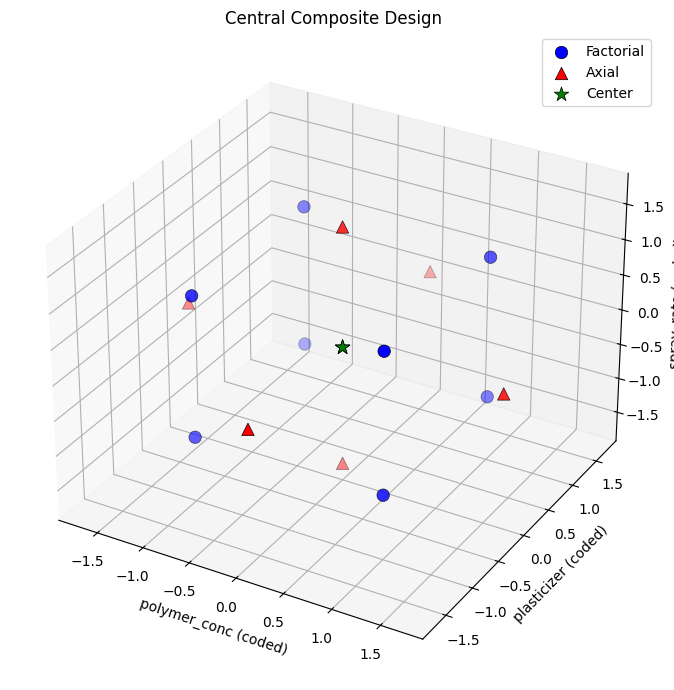

In [4]:
# Visualize the design in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Convert to coded variables for visualization
X_coded = rs.encode(X_design)

# Color by point type
n_factorial = 2**3
n_axial = 2 * 3
n_center = 3

ax.scatter(X_coded[:n_factorial, 0], X_coded[:n_factorial, 1], X_coded[:n_factorial, 2],
           c="blue", s=80, label="Factorial", edgecolors="black", linewidth=0.5)
ax.scatter(X_coded[n_factorial:n_factorial+n_axial, 0],
           X_coded[n_factorial:n_factorial+n_axial, 1],
           X_coded[n_factorial:n_factorial+n_axial, 2],
           c="red", s=80, marker="^", label="Axial", edgecolors="black", linewidth=0.5)
ax.scatter(X_coded[n_factorial+n_axial:, 0],
           X_coded[n_factorial+n_axial:, 1],
           X_coded[n_factorial+n_axial:, 2],
           c="green", s=120, marker="*", label="Center", edgecolors="black", linewidth=0.5)

ax.set_xlabel("polymer_conc (coded)")
ax.set_ylabel("plasticizer (coded)")
ax.set_zlabel("spray_rate (coded)")
ax.set_title("Central Composite Design")
ax.legend()
plt.tight_layout()
plt.show()

## Step 2: Run Experiments

In a real study, you would run the experiments in the lab and record the response.
Here we simulate a response surface with a known quadratic model:

$$y = 80 + 5x_1 + 3x_2 - 2x_3 - 4x_1^2 - 3x_2^2 - 2x_3^2 + 2x_1 x_2 - x_1 x_3 + \varepsilon$$

In [5]:
def simulate_response(X):
    """Simulate the tablet coating process.

    Replace this function with actual experimental measurements.
    The response is a uniformity score (0-100).
    """
    # Work in coded variables for a clean quadratic model
    Xc = np.zeros_like(X)
    for j in range(X.shape[1]):
        lo, hi = BOUNDS[j]
        Xc[:, j] = 2 * (X[:, j] - lo) / (hi - lo) - 1  # encode to [-1, 1]

    x1, x2, x3 = Xc[:, 0], Xc[:, 1], Xc[:, 2]

    # True response surface (unknown to experimenter)
    y = (
        80
        + 5 * x1 + 3 * x2 - 2 * x3
        - 4 * x1**2 - 3 * x2**2 - 2 * x3**2
        + 2 * x1 * x2 - 1 * x1 * x3
    )
    noise = np.random.randn(len(y)) * 1.5  # Measurement noise
    return y + noise


# Run experiments
y_obs = simulate_response(X_design)

print(f"Collected {len(y_obs)} observations")
print(f"Response range: [{y_obs.min():.1f}, {y_obs.max():.1f}]")
print(f"Mean response: {y_obs.mean():.1f}")
print(f"Response std: {y_obs.std():.1f}")

Collected 17 observations
Response range: [61.1, 86.4]
Mean response: 72.6
Response std: 6.5


## Step 3: Fit the Response Surface Model

The `ResponseSurface` object automatically builds a quadratic basis library
(constant + linear + quadratic + interactions) and fits using symbolic regression.

JAXSR may discover that some quadratic or interaction terms are not needed —
giving you a simpler model than the full quadratic.

In [6]:
# Fit the response surface
rs.fit(X_design, y_obs)

model = rs.model
print(model.summary())
print(f"\nExpression: {model.expression_}")
print(f"R²: {model.metrics_['r2']:.6f}")
print(f"MSE: {model.metrics_['mse']:.6g}")
print(f"Estimated noise (sigma): {model.sigma_:.4f}")

JAXSR Symbolic Regression Model

Expression: y = 66.94 + 0.5509*polymer_conc*plasticizer - 0.3416*plasticizer*spray_rate

Selected terms (3):
  1: 66.9441
  polymer_conc*plasticizer: 0.550859
  plasticizer*spray_rate: -0.341642

Metrics:
  MSE: 10.6727
  R²: 0.745588
  BIC: 96.99
  AIC: 94.49
  Complexity: 4

Training samples: 17
Strategy: greedy_forward

Expression: y = 66.94 + 0.5509*polymer_conc*plasticizer - 0.3416*plasticizer*spray_rate
R²: 0.745588
MSE: 10.6727
Estimated noise (sigma): 3.6000


## Step 4: ANOVA

ANOVA tests the statistical significance of each model term.
Terms with large F-values (small p-values) are statistically significant.

In [7]:
# Run ANOVA
anova_result = rs.anova(anova_type="sequential")

print("ANOVA Table (Type I — Sequential)")
print("=" * 85)
print(f"  {'Source':22s}  {'DF':>4}  {'Sum Sq':>10}  {'Mean Sq':>10}  {'F-value':>10}  {'p-value':>10}  {'Sig':>3}")
print("-" * 85)

summary_sources = {"Model", "Residual", "Total"}
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "

    # Significance stars
    if row.p_value is not None:
        sig = "***" if row.p_value < 0.001 else ("**" if row.p_value < 0.01 else (
            "*" if row.p_value < 0.05 else ""))
    else:
        sig = ""

    prefix = "  " if row.source not in summary_sources else "> "
    print(f"{prefix}{row.source:22s}  {row.df:4d}  {row.sum_sq:10.2f}  {row.mean_sq:10.2f}  {f_str}  {p_str}  {sig:>3}")

    if row.source == "Total":
        break

print("-" * 85)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")

ANOVA Table (Type I — Sequential)
  Source                    DF      Sum Sq     Mean Sq     F-value     p-value  Sig
-------------------------------------------------------------------------------------
  1                          1        0.00        0.00        0.00      1.0000     
  polymer_conc*plasticizer     1      474.51      474.51       36.61      0.0000  ***
  plasticizer*spray_rate     1       57.21       57.21        4.41      0.0542     
> Model                      2      531.72      265.86       20.51      0.0001  ***
> Residual                  14      181.44       12.96                             
> Total                     16      713.16       44.57                             
-------------------------------------------------------------------------------------
Significance: *** p<0.001, ** p<0.01, * p<0.05


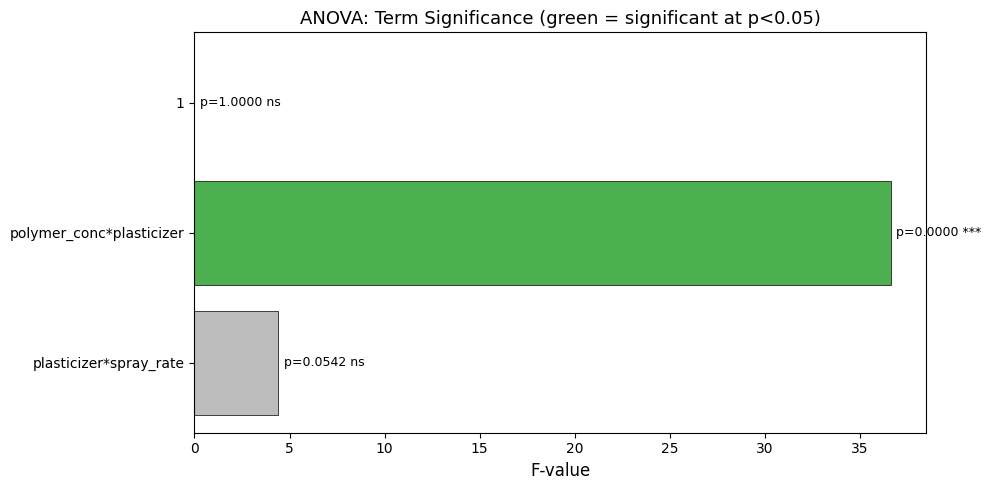

In [8]:
# Visualize ANOVA — F-values for significant terms
term_rows = [r for r in anova_result.rows if r.source not in summary_sources and r.f_value is not None]

names = [r.source for r in term_rows]
f_values = [r.f_value for r in term_rows]
p_values = [r.p_value for r in term_rows]
colors = ["#4CAF50" if p < 0.05 else "#BDBDBD" for p in p_values]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(names, f_values, color=colors, edgecolor="black", linewidth=0.5)

# Add p-value annotations
for bar, p in zip(bars, p_values, strict=False):
    sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f"p={p:.4f} {sig}", va="center", fontsize=9)

ax.set_xlabel("F-value", fontsize=12)
ax.set_title("ANOVA: Term Significance (green = significant at p<0.05)", fontsize=13)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Step 5: Diagnostic Plots

Check model assumptions: normality, constant variance, no patterns in residuals.

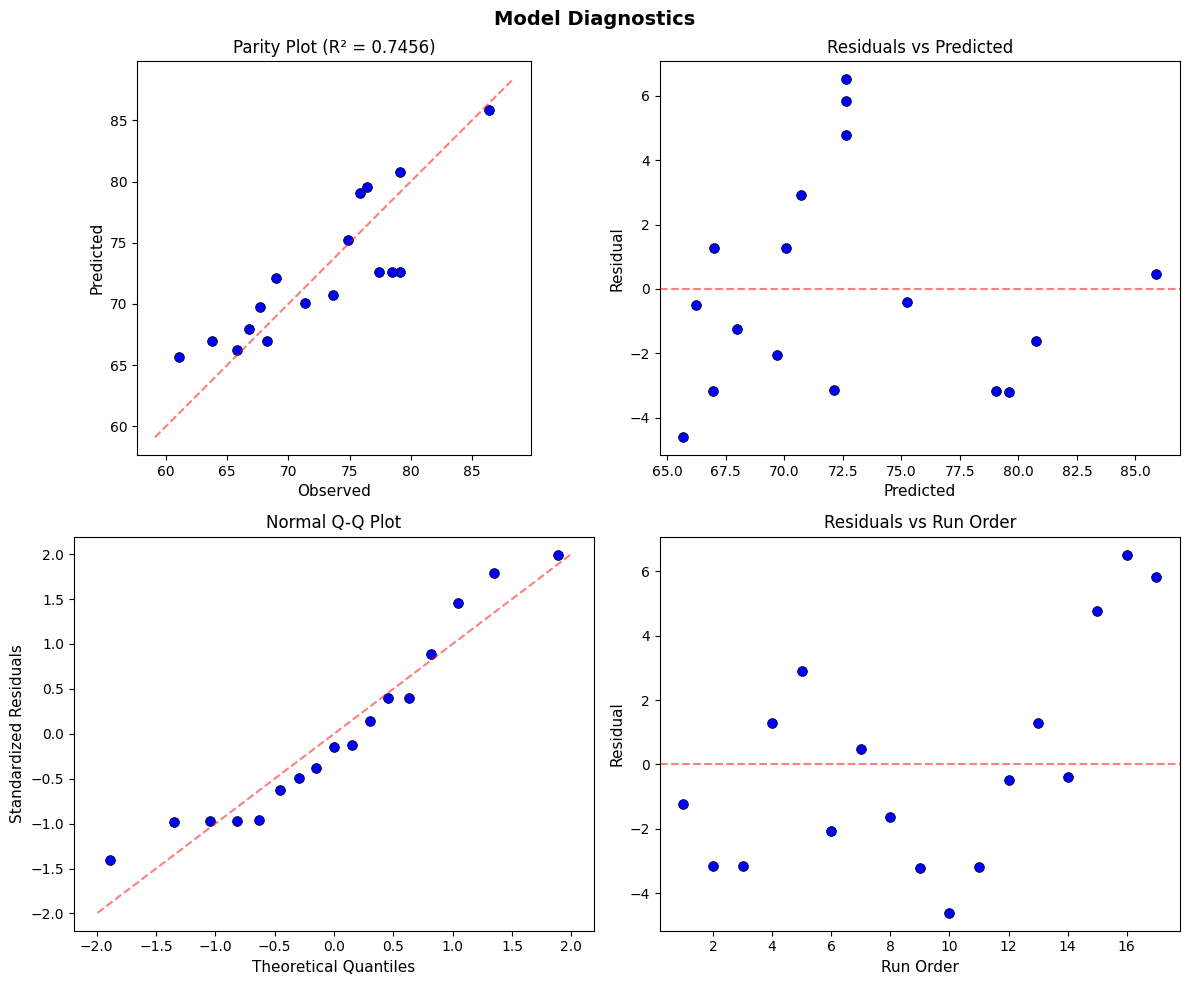

Residual statistics:
  Mean: -0.0000 (should be ~0)
  Std:  3.2669
  Max |residual|: 6.5119


In [9]:
# Predictions and residuals
y_pred = np.asarray(model.predict(jnp.array(X_design)))
residuals = y_obs - y_pred
std_residuals = residuals / residuals.std()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Parity plot (predicted vs actual)
ax = axes[0, 0]
ax.scatter(y_obs, y_pred, color="blue", s=50, edgecolors="black", linewidth=0.5)
lims = [min(y_obs.min(), y_pred.min()) - 2, max(y_obs.max(), y_pred.max()) + 2]
ax.plot(lims, lims, "r--", alpha=0.5, linewidth=1.5)
ax.set_xlabel("Observed", fontsize=11)
ax.set_ylabel("Predicted", fontsize=11)
ax.set_title(f"Parity Plot (R² = {model.metrics_['r2']:.4f})", fontsize=12)
ax.set_aspect("equal")

# 2. Residuals vs predicted
ax = axes[0, 1]
ax.scatter(y_pred, residuals, color="blue", s=50, edgecolors="black", linewidth=0.5)
ax.axhline(y=0, color="r", linestyle="--", alpha=0.5)
ax.set_xlabel("Predicted", fontsize=11)
ax.set_ylabel("Residual", fontsize=11)
ax.set_title("Residuals vs Predicted", fontsize=12)

# 3. Normal probability plot (Q-Q)
from scipy.special import erfinv

ax = axes[1, 0]
sorted_res = np.sort(std_residuals)
n = len(sorted_res)
theoretical = np.array([np.sqrt(2) * erfinv(2 * (i + 0.5) / n - 1) for i in range(n)])
ax.scatter(theoretical, sorted_res, color="blue", s=50, edgecolors="black", linewidth=0.5)
qq_lim = max(abs(theoretical.min()), abs(theoretical.max()), abs(sorted_res.min()), abs(sorted_res.max()))
ax.plot([-qq_lim, qq_lim], [-qq_lim, qq_lim], "r--", alpha=0.5)
ax.set_xlabel("Theoretical Quantiles", fontsize=11)
ax.set_ylabel("Standardized Residuals", fontsize=11)
ax.set_title("Normal Q-Q Plot", fontsize=12)

# 4. Residuals vs run order
ax = axes[1, 1]
ax.scatter(range(1, len(residuals) + 1), residuals, color="blue", s=50,
           edgecolors="black", linewidth=0.5)
ax.axhline(y=0, color="r", linestyle="--", alpha=0.5)
ax.set_xlabel("Run Order", fontsize=11)
ax.set_ylabel("Residual", fontsize=11)
ax.set_title("Residuals vs Run Order", fontsize=12)

plt.suptitle("Model Diagnostics", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("Residual statistics:")
print(f"  Mean: {residuals.mean():.4f} (should be ~0)")
print(f"  Std:  {residuals.std():.4f}")
print(f"  Max |residual|: {np.abs(residuals).max():.4f}")

## Step 6: Canonical Analysis

Canonical analysis finds the **stationary point** of the quadratic surface and
classifies it as a maximum, minimum, or saddle point.

- All eigenvalues negative → **maximum** (ideal for maximizing response)
- All eigenvalues positive → **minimum**
- Mixed signs → **saddle point** (ridge system)

In [10]:
# Canonical analysis
ca = rs.canonical()

print("Canonical Analysis")
print("=" * 60)
print("\nStationary point (natural units):")
for name, val, (lo, hi), unit in zip(FACTOR_NAMES, ca.stationary_point, BOUNDS, UNITS, strict=True):
    in_range = "  (in range)" if lo <= val <= hi else "  *** OUT OF RANGE ***"
    print(f"  {name:20s} = {val:8.3f} {unit}{in_range}")

print(f"\nPredicted response at stationary point: {ca.stationary_response:.2f}")
print(f"Nature: {ca.nature}")

print(f"\nEigenvalues: {ca.eigenvalues}")
print("Interpretation:")
if all(e < 0 for e in ca.eigenvalues):
    print("  All eigenvalues negative → MAXIMUM")
    print("  The stationary point is the optimal formulation.")
elif all(e > 0 for e in ca.eigenvalues):
    print("  All eigenvalues positive → MINIMUM")
else:
    print("  Mixed eigenvalues → SADDLE POINT")
    print("  Consider exploring along the ridge.")

Canonical Analysis

Stationary point (natural units):
  polymer_conc         =      nan % w/w  *** OUT OF RANGE ***
  plasticizer          =      nan % w/w  *** OUT OF RANGE ***
  spray_rate           =      nan mL/min  *** OUT OF RANGE ***

Predicted response at stationary point: nan
Nature: saddle

Eigenvalues: [-3.24100670e-01  3.63061264e-17  3.24100670e-01]
Interpretation:
  Mixed eigenvalues → SADDLE POINT
  Consider exploring along the ridge.


In [11]:
# Predict at the stationary point with uncertainty
X_opt = np.array([ca.stationary_point])
y_opt, opt_lo, opt_hi = model.predict_interval(jnp.array(X_opt), alpha=0.05)

print("Prediction at optimum:")
print(f"  Uniformity score = {float(y_opt[0]):.2f}")
print(f"  95% PI: [{float(opt_lo[0]):.2f}, {float(opt_hi[0]):.2f}]")

# Coefficient significance with t-statistics and p-values
from scipy import stats as sp_stats

print("\nCoefficient Significance (95% CI):")
intervals = model.coefficient_intervals(alpha=0.05)
n, k = len(y_obs), len(model.selected_features_)
df = n - k

print(f"  {'Term':>25s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 85)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df))) if df > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>25s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

Prediction at optimum:
  Uniformity score = nan
  95% PI: [nan, nan]

Coefficient Significance (95% CI):
                       Term   Estimate   Std Err        t    p-value 95% CI
  -------------------------------------------------------------------------------------
                          1    66.9441    1.5059    44.46   2.22e-16 [63.7143, 70.1738] ***
   polymer_conc*plasticizer     0.5509    0.0884     6.23   2.20e-05 [0.3612, 0.7405] ***
     plasticizer*spray_rate    -0.3416    0.1626    -2.10   5.42e-02 [-0.6904, 0.0071] 
  --- *** p<0.001, ** p<0.01, * p<0.05


## Step 7: Contour Plots

Visualize the response surface by holding one factor at its optimal value
and plotting contours for the other two factors.

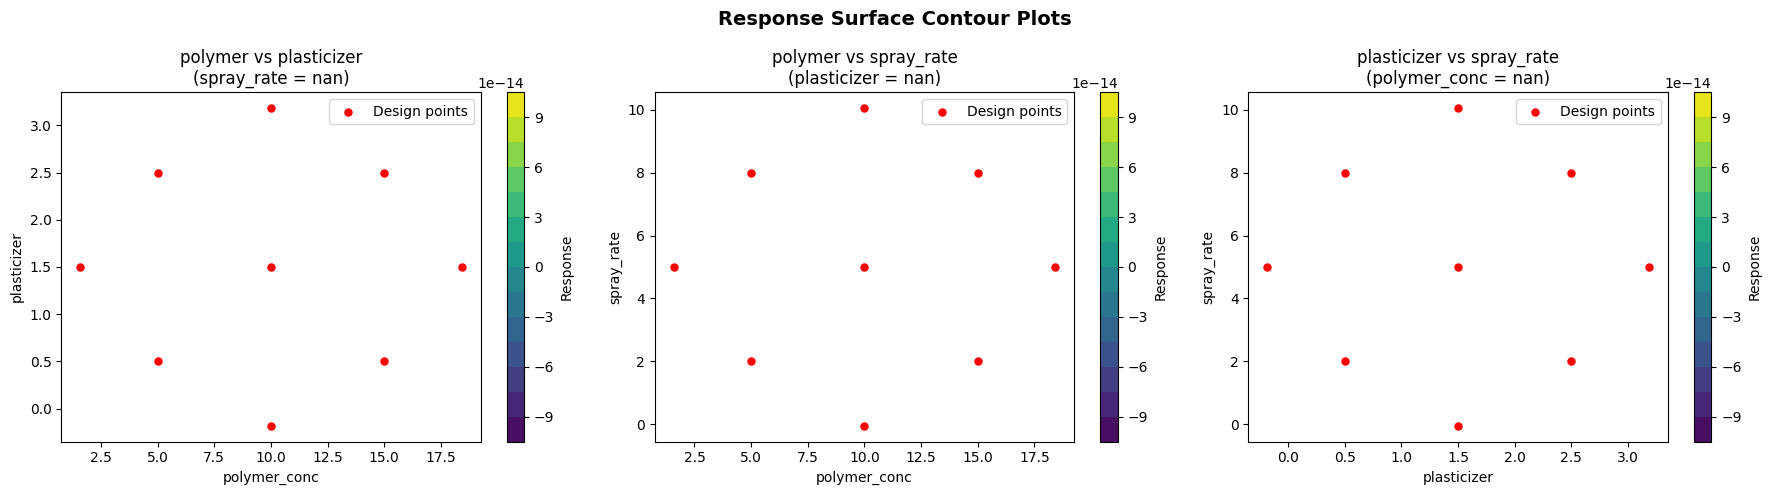

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Determine optimal values for fixing variables
sp = ca.stationary_point

# Contour 1: polymer_conc vs plasticizer (spray_rate fixed at optimum)
rs.plot_contour(
    factors=(0, 1),
    fixed={2: sp[2]},
    ax=axes[0],
    n_grid=50,
    levels=15,
    filled=True,
    show_design=True,
)
axes[0].set_title(f"polymer vs plasticizer\n(spray_rate = {sp[2]:.1f})")

# Contour 2: polymer_conc vs spray_rate (plasticizer fixed at optimum)
rs.plot_contour(
    factors=(0, 2),
    fixed={1: sp[1]},
    ax=axes[1],
    n_grid=50,
    levels=15,
    filled=True,
    show_design=True,
)
axes[1].set_title(f"polymer vs spray_rate\n(plasticizer = {sp[1]:.2f})")

# Contour 3: plasticizer vs spray_rate (polymer_conc fixed at optimum)
rs.plot_contour(
    factors=(1, 2),
    fixed={0: sp[0]},
    ax=axes[2],
    n_grid=50,
    levels=15,
    filled=True,
    show_design=True,
)
axes[2].set_title(f"plasticizer vs spray_rate\n(polymer_conc = {sp[0]:.1f})")

plt.suptitle("Response Surface Contour Plots", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Step 8: Perturbation Analysis

Show how each factor affects the response when varied from the center point
while holding other factors at their center values.

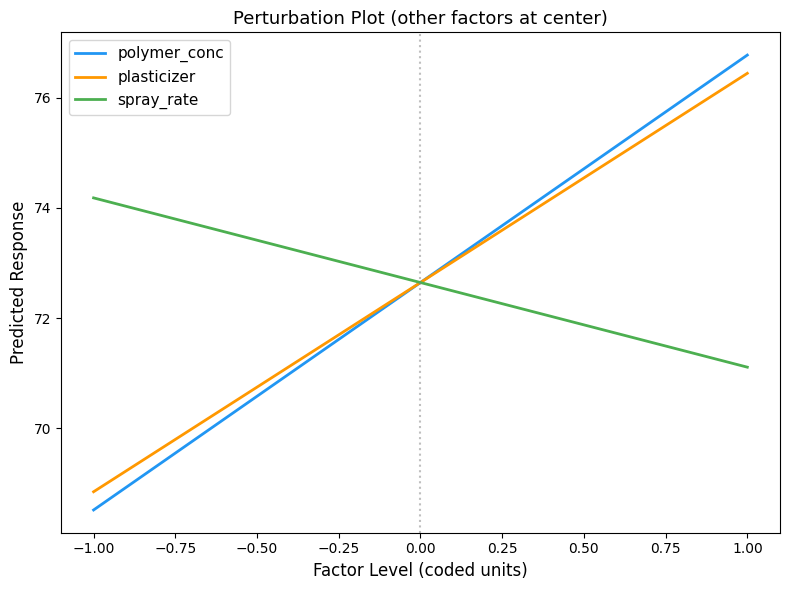

Steeper curves = factor has more influence on the response.


In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

center = np.array([(lo + hi) / 2 for lo, hi in BOUNDS])
colors = ["#2196F3", "#FF9800", "#4CAF50"]

for j, (name, color) in enumerate(zip(FACTOR_NAMES, colors, strict=False)):
    lo, hi = BOUNDS[j]
    x_range = np.linspace(lo, hi, 50)

    # Vary factor j, hold others at center
    X_sweep = np.tile(center, (50, 1))
    X_sweep[:, j] = x_range

    y_sweep = np.asarray(model.predict(jnp.array(X_sweep)))

    # Normalize x-axis to coded units for comparison
    x_coded = 2 * (x_range - lo) / (hi - lo) - 1

    ax.plot(x_coded, y_sweep, color=color, linewidth=2, label=name)

ax.set_xlabel("Factor Level (coded units)", fontsize=12)
ax.set_ylabel("Predicted Response", fontsize=12)
ax.set_title("Perturbation Plot (other factors at center)", fontsize=13)
ax.axvline(x=0, color="gray", linestyle=":", alpha=0.5)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("Steeper curves = factor has more influence on the response.")

## Step 9: Optimization Summary

In [14]:
print("╔" + "═" * 65 + "╗")
print("║" + " RSM FORMULATION OPTIMIZATION — FINAL REPORT".center(65) + "║")
print("╠" + "═" * 65 + "╣")
print("║" + " Model Summary".center(65) + "║")
print("║" + "-" * 65 + "║")
print(f"║  Expression: {model.expression_}")
print(f"║  R² = {model.metrics_['r2']:.6f}")
print(f"║  MSE = {model.metrics_['mse']:.4f}")
print(f"║  Terms = {len(model.selected_features_)}")
print("╠" + "═" * 65 + "╣")
print("║" + " Optimal Formulation".center(65) + "║")
print("║" + "-" * 65 + "║")
for name, val, unit in zip(FACTOR_NAMES, ca.stationary_point, UNITS, strict=True):
    print(f"║  {name:20s} = {val:8.3f} {unit}")
print("║")
print(f"║  Predicted uniformity = {ca.stationary_response:.1f}")
print(f"║  95% PI: [{float(opt_lo[0]):.1f}, {float(opt_hi[0]):.1f}]")
print(f"║  Stationary point: {ca.nature}")
print("╠" + "═" * 65 + "╣")
print("║" + " LaTeX".center(65) + "║")
print("║" + "-" * 65 + "║")
print(f"║  ${model.to_latex()}$")
print("╚" + "═" * 65 + "╝")

╔═════════════════════════════════════════════════════════════════╗
║            RSM FORMULATION OPTIMIZATION — FINAL REPORT          ║
╠═════════════════════════════════════════════════════════════════╣
║                           Model Summary                         ║
║-----------------------------------------------------------------║
║  Expression: y = 66.94 + 0.5509*polymer_conc*plasticizer - 0.3416*plasticizer*spray_rate
║  R² = 0.745588
║  MSE = 10.6727
║  Terms = 3
╠═════════════════════════════════════════════════════════════════╣
║                        Optimal Formulation                      ║
║-----------------------------------------------------------------║
║  polymer_conc         =      nan % w/w
║  plasticizer          =      nan % w/w
║  spray_rate           =      nan mL/min
║
║  Predicted uniformity = nan
║  95% PI: [nan, nan]
║  Stationary point: saddle
╠═════════════════════════════════════════════════════════════════╣
║                               LaTeX       

║  $0.550859153270721 plasticizer polymer_{conc} - 0.341641873121262 plasticizer spray_{rate} + 66.9440536499023$
╚═════════════════════════════════════════════════════════════════╝


In [15]:
# Save model for deployment
model.save("formulation_model.json")

# Export pure NumPy callable
predict_fn = model.to_callable()

# Verify at the optimum
y_check = predict_fn(np.array([ca.stationary_point]))
print(f"NumPy callable prediction at optimum: {y_check[0]:.2f}")

# Clean up
import os

if os.path.exists("formulation_model.json"):
    os.remove("formulation_model.json")

NumPy callable prediction at optimum: nan


## Summary

This notebook demonstrated the complete RSM workflow for formulation optimization:

1. **CCD Design** — 17-run Central Composite Design with center replicates
2. **Quadratic Model** — Full second-order polynomial fitted via symbolic regression
3. **ANOVA** — Identified significant terms and their F-statistics
4. **Diagnostics** — Verified normality, constant variance, and independence
5. **Canonical Analysis** — Found the stationary point and classified it
6. **Contour Plots** — Visualized the response surface for all factor pairs
7. **Perturbation Analysis** — Compared factor sensitivities

### Key Design Choices

| Choice | Recommendation |
|--------|---------------|
| Design | CCD for quadratic models; Box-Behnken if corner points are infeasible |
| Center points | 3-5 replicates for pure error and lack-of-fit testing |
| Model | Start with full quadratic; JAXSR automatically removes insignificant terms |
| Analysis | Always check ANOVA, residuals, and canonical analysis before reporting |
| Stationary point | If outside bounds, report the best point on the boundary instead |